In [1]:
import xarray as xr
from datetime import datetime, timedelta
import sys
sys.path.append("..")
from ufs2arco import MOM6Dataset, MOM6Regridder
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cf_xarray as cfxr

##### get one timestep of 1 deg data

In [9]:
def ocean_path(cycles, forecast_hours, file_prefixes):

    upper = "s3://noaa-ufs-gefsv13replay-pds"
    cycles = [cycles] if not isinstance(cycles, list) else cycles

    files = []
    for cycle in cycles:
        this_dir = f"{cycle.year:04d}/{cycle.month:02d}/{cycle.year:04d}{cycle.month:02d}{cycle.day:02d}{cycle.hour:02d}"
        for fp in file_prefixes:
            for fhr in forecast_hours:
                this_date = cycle+timedelta(hours=fhr)
                this_file = f"{this_dir}/{fp}{this_date.year:04d}_{this_date.month:02d}_{this_date.day:02d}_{this_date.hour:02d}.nc"
                files.append(this_file)
    return [f"{upper}/{this_file}" for this_file in files]

cycles = [datetime(1996,1,1,0)]

def cached_path(cycles, forecast_hours, file_prefixes):
    return [f"simplecache::{u}" for u in ocean_path(cycles, forecast_hours, file_prefixes)]

reader = MOM6Dataset(path_in=cached_path, config_filename="config-replay.yaml")
ds = reader.open_dataset(cycles, fsspec_kwargs={"s3":{"anon":True}}, engine="h5netcdf")

MOM6Dataset.__init__: Could not find coords_path_out in config-replay.yaml, using default.


/Users/mariahpope/Desktop/repos/ufs2arco/docs/../ufs2arco/ufsdataset.py:291: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  xtime = xr.DataArray(


#### create ds_out

In [10]:
fv3_grid = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)
fv3_grid = fv3_grid[['grid_yt','grid_xt']]
fv3_grid = fv3_grid.rename({"grid_yt":"lat","grid_xt":"lon"})

# calculates "corners"
fv3_grid = fv3_grid.cf.add_bounds(["latitude", "longitude"])

lat_corners = cfxr.bounds_to_vertices(
    bounds = fv3_grid['lat_bounds'], 
    bounds_dim="bounds",
    order=None
)
lon_corners = cfxr.bounds_to_vertices(
    bounds = fv3_grid['lon_bounds'], 
    bounds_dim="bounds",
    order=None
)
fv3_grid = fv3_grid.assign({
    "lat_b":lat_corners,
    "lon_b":lon_corners
})
fv3_grid = fv3_grid.drop_vars(['lat_bounds','lon_bounds'])

#### create ds_in

In [11]:
# from here: https://mom6-analysiscookbook.readthedocs.io/en/latest/notebooks/Horizontal_Remapping.html
# takes our mom6 grid and creates corners

mom6_grid = xr.open_dataset('mom6_grid_0.25_degree.nc')
def grid_model_sym_approx(grid):
    grid_model = xr.Dataset()
    grid_model['lon'] = grid['geolon']
    grid_model['lat'] = grid['geolat']

    ny, nx = grid_model['lon'].shape

    lon_b = np.empty((ny+1, nx+1))
    lat_b = np.empty((ny+1, nx+1))

    lon_b[1:, 1:] = grid['geolon_c'].values
    lat_b[1:, 1:] = grid['geolat_c'].values

    # periodicity
    lon_b[:, 0] = lon_b[:, -1]
    lat_b[:, 0] = lat_b[:, -1]

    # south edge
    dy = (lat_b[2,:] - lat_b[1,:]).mean()
    lat_b[0, 1:] = lat_b[1,1:] - dy
    lon_b[0, 1:] = lon_b[1, 1:]

    # corner point
    lon_b[0, 0] = lon_b[1,0]
    lat_b[0,0] = lat_b[0,1]

    grid_model['lon_b'] = xr.DataArray(data=lon_b)
    grid_model['lat_b'] = xr.DataArray(data=lat_b)
    return grid_model
mom6_grid = grid_model_sym_approx(mom6_grid)

In [12]:
regridder = xe.Regridder(mom6_grid, fv3_grid, 'conservative', periodic=True)
new_ds = regridder(ds)
new_ds = new_ds.where(new_ds!=0)

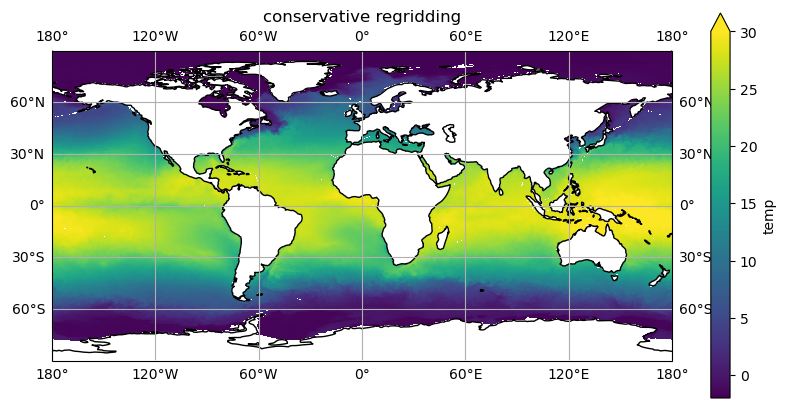

In [13]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], 
              ccrs.PlateCarree()
              )
cmap = plt.cm.viridis
ax.coastlines()
new_ds['temp'][0,0,:,:].plot(ax=ax, 
        transform=ccrs.PlateCarree(), 
        cmap='viridis',
        vmin=-2,
        vmax=30
        )  
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.title('conservative regridding')
plt.show()

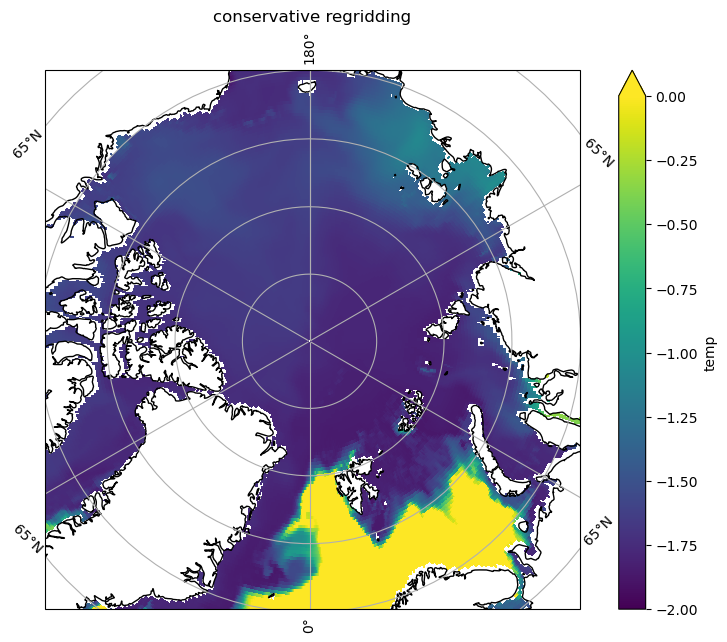

In [14]:
projection = ccrs.NorthPolarStereo()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=projection)
ax.set_extent([-180, 180, 70, 90], 
              ccrs.PlateCarree()
              )
ax.coastlines()

new_ds['temp'][0,0,:,:].plot(ax=ax, 
                             transform=ccrs.PlateCarree(), 
                             cmap='viridis',
                             vmin=-2,
                             vmax=0
                             )  
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
plt.title('conservative regridding')
plt.show()